In [1]:
import os
import sys
import re

project_root = "/root/work/tenset"
os.environ["TVM_HOME"] = f"{project_root}"
os.environ["TVM_LIBRARY_PATH"] = f"{project_root}/build"
if f"{project_root}/python" not in sys.path:
    sys.path.insert(0, f"{project_root}/python")

sys.path = [p for p in sys.path if not p.startswith(f"{project_root}/build")]
sys.path.append(f"{project_root}/build")
os.environ["LD_LIBRARY_PATH"] = f"{project_root}/build:" + os.environ.get("LD_LIBRARY_PATH", "")

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

class NpzRegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
        # y shape이 (N,)이면 (N,1)로 바꿔주는 게 편할 때가 많음
        if self.y.ndim == 1:
            self.y = self.y.unsqueeze(1)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [3]:
import numpy as np
import torch

# record_index
# vector_index
# diff_indices
# diff_values
# cost

json_diffs = np.load("../i_vectors_diffs.npz")

input_data = np.log(json_diffs["diff_values"]+1e-8)
# input_data = json_diffs["diff_values"]
cost = -np.log(json_diffs["cost"])

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_val, y_train, y_val = train_test_split(
    input_data, cost, test_size=0.2, random_state=42
)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

train_dataset = NpzRegressionDataset(X_train_scaled, y_train)
val_dataset   = NpzRegressionDataset(X_val_scaled,   y_val)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=128, shuffle=False)

In [7]:
import torch.nn as nn

# ==========================================
# 1. VAE Encoder (vae_rep_sch_param_v1 기반)
# ==========================================
class ImprovedVAEEncoder(nn.Module):
    """
    Pretrained VAE에서 encoder 부분만 사용.
    완전 미분 가능 - forward에서 detach나 stop_grad 없음.
    """
    def __init__(self, input_dim, hidden_dim=1024, latent_dim=64, 
                 activation="gelu", dropout=0.1, use_bn=True, use_residual=True):
        super(ImprovedVAEEncoder, self).__init__()
        
        self.use_residual = use_residual
        self.latent_dim = latent_dim
        
        # Activation
        activations = {
            'relu': nn.ReLU(),
            'gelu': nn.GELU(),
            'elu': nn.ELU(),
            'leakyrelu': nn.LeakyReLU(0.2),
            'silu': nn.SiLU(),
        }
        self.activation = activations.get(activation, nn.GELU())
        
        def get_norm(dim):
            return nn.BatchNorm1d(dim) if use_bn else nn.Identity()
        
        # Encoder layers
        self.enc_input = nn.Linear(input_dim, hidden_dim)
        self.enc_norm1 = get_norm(hidden_dim)
        self.enc_drop1 = nn.Dropout(dropout)
        
        self.enc_hidden1 = nn.Linear(hidden_dim, hidden_dim)
        self.enc_norm2 = get_norm(hidden_dim)
        self.enc_drop2 = nn.Dropout(dropout)
        
        self.enc_hidden2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.enc_norm3 = get_norm(hidden_dim // 2)
        self.enc_drop3 = nn.Dropout(dropout)
        
        self.enc_hidden3 = nn.Linear(hidden_dim // 2, hidden_dim // 4)
        self.enc_norm4 = get_norm(hidden_dim // 4)
        
        # Latent space parameters (mu, logvar)
        self.fc_mean = nn.Linear(hidden_dim // 4, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim // 4, latent_dim)
        
        # Residual projection
        self.res_proj1 = nn.Linear(hidden_dim, hidden_dim // 2) if use_residual else None
    
    def forward(self, x, deterministic=False):
        """
        Args:
            x: input features
            deterministic: True면 z=mean, False면 reparameterization sampling
        Returns:
            z: latent vector (완전 미분 가능)
            mean, logvar: latent distribution parameters
        """
        h = self.enc_input(x)
        h = self.enc_norm1(h)
        h = self.activation(h)
        h = self.enc_drop1(h)
        
        h_res = h
        h = self.enc_hidden1(h)
        h = self.enc_norm2(h)
        h = self.activation(h)
        if self.use_residual:
            h = h + h_res
        h = self.enc_drop2(h)
        
        if self.use_residual and self.res_proj1 is not None:
            h_res = self.res_proj1(h)
        h = self.enc_hidden2(h)
        h = self.enc_norm3(h)
        h = self.activation(h)
        h = self.enc_drop3(h)
        
        h = self.enc_hidden3(h)
        h = self.enc_norm4(h)
        h = self.activation(h)
        
        mean = self.fc_mean(h)
        logvar = self.fc_logvar(h)
        
        # Reparameterization trick (완전 미분 가능)
        if deterministic:
            z = mean
        else:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            z = mean + eps * std
        
        return z, mean, logvar


# ==========================================
# 2. Cost Predictor (vib_mlp_sch_param_v1 기반)
# ==========================================
class CostPredictor(nn.Module):
    """
    Latent z에서 cost를 예측하는 MLP.
    Gradient 품질을 위해 dropout 최소화.
    """
    def __init__(self, latent_dim, hidden_dims=[256, 128, 64], dropout=0.05):
        super(CostPredictor, self).__init__()
        
        layers = []
        in_dim = latent_dim
        for h_dim in hidden_dims:
            layers.extend([
                nn.Linear(in_dim, h_dim),
                nn.LayerNorm(h_dim),  # LayerNorm for stable gradients
                nn.GELU(),
                nn.Dropout(dropout),  # 낮은 dropout
            ])
            in_dim = h_dim
        
        layers.append(nn.Linear(in_dim, 1))
        self.net = nn.Sequential(*layers)
    
    def forward(self, z):
        return self.net(z)


# ==========================================
# 3. 통합 모델: VAE Encoder + Cost Predictor
# ==========================================
class VAECostRegressor(nn.Module):
    """
    VAE encoder + Cost predictor 통합 모델.
    Gradient ∂cost/∂z 계산을 위해 완전 미분 가능.
    """
    def __init__(self, encoder, cost_predictor):
        super(VAECostRegressor, self).__init__()
        self.encoder = encoder
        self.cost_predictor = cost_predictor
    
    def forward(self, x, deterministic=False):
        """
        Args:
            x: input features
            deterministic: True면 z=mean 사용
        Returns:
            cost_pred: 예측된 cost
            z: latent vector
            mean, logvar: VAE distribution parameters
        """
        z, mean, logvar = self.encoder(x, deterministic=deterministic)
        cost_pred = self.cost_predictor(z)
        return cost_pred, z, mean, logvar
    
    def get_gradient_wrt_z(self, x, deterministic=True):
        """
        z에 대한 cost gradient 계산 (∂cost/∂z).
        """
        # Ensure gradients flow through z
        z, mean, logvar = self.encoder(x, deterministic=deterministic)
        z = z.requires_grad_(True)
        cost = self.cost_predictor(z)
        
        # Compute gradient
        grad_z = torch.autograd.grad(
            outputs=cost.sum(),
            inputs=z,
            create_graph=True,
            retain_graph=True
        )[0]
        
        return grad_z, cost, z


# ==========================================
# 4. Pretrained VAE 로딩 함수
# ==========================================
def load_pretrained_encoder(pth_path, input_dim, device):
    """
    Pretrained VAE에서 encoder 가중치만 로드.
    """
    checkpoint = torch.load(pth_path, map_location=device)
    config = checkpoint['config']
    
    encoder = ImprovedVAEEncoder(
        input_dim=input_dim,
        hidden_dim=config['hidden_dim'],
        latent_dim=config['latent_dim'],
        activation=config['activation'],
        dropout=config['dropout'],
        use_bn=config['use_bn'],
        use_residual=config['use_residual'],
    )
    
    # VAE state dict에서 encoder 관련 키만 추출
    vae_state = checkpoint['model_state_dict']
    encoder_state = {}
    for k, v in vae_state.items():
        if k.startswith('enc_') or k.startswith('fc_mean') or k.startswith('fc_logvar') or k.startswith('res_proj'):
            encoder_state[k] = v
    
    encoder.load_state_dict(encoder_state, strict=False)
    return encoder, config


print("✅ VAE Encoder + Cost Predictor 클래스 정의 완료")
print(f"   - ImprovedVAEEncoder: Pretrained VAE의 encoder")
print(f"   - CostPredictor: z → cost 회귀 MLP")
print(f"   - VAECostRegressor: 통합 모델 (완전 미분 가능)")

✅ VAE Encoder + Cost Predictor 클래스 정의 완료
   - ImprovedVAEEncoder: Pretrained VAE의 encoder
   - CostPredictor: z → cost 회귀 MLP
   - VAECostRegressor: 통합 모델 (완전 미분 가능)


In [8]:
# ==========================================
# 5. Loss Functions
# ==========================================

def reg_loss_fn(cost_pred, cost_true, loss_type='mse'):
    """
    기본 회귀 손실 (MSE 또는 MAE)
    """
    if loss_type == 'mse':
        return F.mse_loss(cost_pred, cost_true)
    else:  # mae
        return F.l1_loss(cost_pred, cost_true)


def pair_loss_fn(cost_pred, cost_true, margin=0.1):
    """
    Pairwise ranking loss: 실제 cost 순서를 예측이 유지하도록.
    cost_true[i] < cost_true[j] 이면 cost_pred[i] < cost_pred[j] + margin
    """
    batch_size = cost_pred.size(0)
    if batch_size < 2:
        return torch.tensor(0.0, device=cost_pred.device)
    
    # 모든 쌍에 대해 ranking loss 계산
    # cost_true[i] < cost_true[j] -> label = 1 (i should be ranked lower)
    idx = torch.arange(batch_size, device=cost_pred.device)
    i_idx, j_idx = torch.meshgrid(idx, idx, indexing='ij')
    mask = i_idx < j_idx  # upper triangular only
    
    pred_i = cost_pred[i_idx[mask]]
    pred_j = cost_pred[j_idx[mask]]
    true_i = cost_true[i_idx[mask]]
    true_j = cost_true[j_idx[mask]]
    
    # label: 1 if true_i < true_j, -1 otherwise
    labels = torch.sign(true_j - true_i).float()
    
    # Margin ranking loss: max(0, -label * (pred_j - pred_i) + margin)
    loss = F.margin_ranking_loss(pred_j, pred_i, labels, margin=margin)
    return loss


def smooth_loss_fn(model, x, z, noise_std=0.1):
    """
    Smoothness loss: z에 작은 노이즈를 더했을 때 예측이 크게 변하지 않도록.
    이는 z 근방에서 cost 함수가 smooth하게 유지되도록 함.
    """
    # Add small noise to z
    z_noisy = z + noise_std * torch.randn_like(z)
    
    # Predict cost for original and noisy z
    cost_original = model.cost_predictor(z)
    cost_noisy = model.cost_predictor(z_noisy)
    
    # L2 consistency loss
    smooth_loss = F.mse_loss(cost_original, cost_noisy)
    return smooth_loss


def kld_loss_fn(mean, logvar):
    """
    KL Divergence: q(z|x) || N(0, I)
    Latent 정규화 용도.
    """
    kld = -0.5 * torch.mean(1 + logvar - mean.pow(2) - logvar.exp())
    return kld


def compute_total_loss(model, x, y, config, return_components=False):
    """
    Total loss 계산.
    total_loss = reg_loss + λ_pair * pair_loss + γ * smooth_loss + β * kld_loss
    """
    # Forward pass
    cost_pred, z, mean, logvar = model(x, deterministic=False)
    
    # Individual losses
    reg = reg_loss_fn(cost_pred, y, loss_type=config.get('loss_type', 'mse'))
    pair = pair_loss_fn(cost_pred, y, margin=config.get('margin', 0.1))
    smooth = smooth_loss_fn(model, x, z, noise_std=config.get('noise_std', 0.1))
    kld = kld_loss_fn(mean, logvar)
    
    # Weighted sum
    total = reg + config['lambda_pair'] * pair + config['gamma'] * smooth + config['beta'] * kld
    
    if return_components:
        return total, {
            'reg_loss': reg.item(),
            'pair_loss': pair.item(),
            'smooth_loss': smooth.item(),
            'kld_loss': kld.item(),
            'total_loss': total.item(),
        }
    return total


print("✅ Loss functions 정의 완료")
print("   - reg_loss_fn: MSE/MAE 회귀 손실")
print("   - pair_loss_fn: Margin ranking 순서 손실")
print("   - smooth_loss_fn: Latent space smoothness 손실")
print("   - kld_loss_fn: KL divergence 정규화")
print("   - compute_total_loss: 통합 손실 함수")

✅ Loss functions 정의 완료
   - reg_loss_fn: MSE/MAE 회귀 손실
   - pair_loss_fn: Margin ranking 순서 손실
   - smooth_loss_fn: Latent space smoothness 손실
   - kld_loss_fn: KL divergence 정규화
   - compute_total_loss: 통합 손실 함수


In [9]:
import random
from collections import deque
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ==========================================
# 6. Training Infrastructure
# ==========================================

class ReplayBuffer:
    """경험 재생을 위한 버퍼"""
    def __init__(self, max_size=10000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, x, y):
        """배치 데이터 추가"""
        for i in range(x.size(0)):
            self.buffer.append((x[i].cpu(), y[i].cpu()))
    
    def sample(self, n):
        """n개 샘플 랜덤 추출"""
        if len(self.buffer) < n:
            n = len(self.buffer)
        samples = random.sample(list(self.buffer), n)
        x = torch.stack([s[0] for s in samples])
        y = torch.stack([s[1] for s in samples])
        return x, y
    
    def __len__(self):
        return len(self.buffer)


class GradientMonitor:
    """z에 대한 gradient 통계 모니터링"""
    def __init__(self):
        self.history = {
            'grad_norm_mean': [],
            'grad_norm_std': [],
            'grad_norm_max': [],
            'grad_norm_min': [],
        }
    
    def record(self, model, x_sample, device):
        """샘플에 대한 gradient 통계 기록"""
        model.eval()
        x_sample = x_sample.to(device)
        
        with torch.enable_grad():
            grad_z, cost, z = model.get_gradient_wrt_z(x_sample, deterministic=True)
        
        grad_norms = grad_z.norm(dim=1).detach().cpu().numpy()
        
        self.history['grad_norm_mean'].append(grad_norms.mean())
        self.history['grad_norm_std'].append(grad_norms.std())
        self.history['grad_norm_max'].append(grad_norms.max())
        self.history['grad_norm_min'].append(grad_norms.min())
        
        model.train()
        return {
            'mean': grad_norms.mean(),
            'std': grad_norms.std(),
            'max': grad_norms.max(),
            'min': grad_norms.min(),
        }


class TrainingLogger:
    """학습 로그 기록"""
    def __init__(self):
        self.phase_logs = []
        self.val_logs = []
    
    def log_phase(self, phase, losses, grad_stats=None):
        entry = {
            'phase': phase,
            **losses,
        }
        if grad_stats:
            entry.update({f'grad_{k}': v for k, v in grad_stats.items()})
        self.phase_logs.append(entry)
    
    def log_validation(self, phase, metrics):
        self.val_logs.append({
            'phase': phase,
            **metrics,
        })
    
    def get_recent_val_mse(self, n=3):
        """최근 n개 phase의 validation MSE 반환"""
        if len(self.val_logs) < n:
            return [log['val_mse'] for log in self.val_logs]
        return [log['val_mse'] for log in self.val_logs[-n:]]


def evaluate_model(model, val_loader, device, config):
    """
    전체 validation set에 대한 평가.
    Deterministic mode (z = mean) 사용.
    """
    model.eval()
    all_preds = []
    all_targets = []
    total_loss = 0.0
    loss_components = {'reg_loss': 0, 'pair_loss': 0, 'smooth_loss': 0, 'kld_loss': 0}
    
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            
            # Deterministic prediction
            cost_pred, z, mean, logvar = model(xb, deterministic=True)
            
            all_preds.append(cost_pred.cpu().numpy())
            all_targets.append(yb.cpu().numpy())
            
            # Loss 계산
            _, components = compute_total_loss(model, xb, yb, config, return_components=True)
            for k in loss_components:
                loss_components[k] += components[k] * xb.size(0)
            total_loss += components['total_loss'] * xb.size(0)
    
    # 평균 계산
    n_samples = len(val_loader.dataset)
    for k in loss_components:
        loss_components[k] /= n_samples
    total_loss /= n_samples
    
    # Metrics 계산
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    
    metrics = {
        'val_mse': mean_squared_error(all_targets, all_preds),
        'val_mae': mean_absolute_error(all_targets, all_preds),
        'val_r2': r2_score(all_targets, all_preds),
        'val_loss': total_loss,
        **{f'val_{k}': v for k, v in loss_components.items()},
    }
    
    model.train()
    return metrics, all_preds, all_targets


def train_phase(model, train_indices, X_train_tensor, y_train_tensor, 
                optimizer_enc, optimizer_cost, device, config, 
                replay_buffer=None, replay_n=0):
    """
    한 phase 학습 (64개 샘플).
    
    Args:
        train_indices: 이번 phase에서 사용할 샘플 인덱스
        replay_buffer: 이전 샘플들을 저장한 버퍼
        replay_n: replay buffer에서 추가로 샘플링할 개수
    """
    model.train()
    
    # Phase 데이터 준비
    x_phase = X_train_tensor[train_indices].to(device)
    y_phase = y_train_tensor[train_indices].to(device)
    
    # Replay buffer에서 추가 샘플
    if replay_buffer and replay_n > 0 and len(replay_buffer) > 0:
        x_replay, y_replay = replay_buffer.sample(replay_n)
        x_phase = torch.cat([x_phase, x_replay.to(device)], dim=0)
        y_phase = torch.cat([y_phase, y_replay.to(device)], dim=0)
    
    # Forward & Loss
    total_loss, components = compute_total_loss(model, x_phase, y_phase, config, return_components=True)
    
    # Backward
    optimizer_enc.zero_grad()
    optimizer_cost.zero_grad()
    total_loss.backward()
    
    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
    optimizer_enc.step()
    optimizer_cost.step()
    
    # Replay buffer에 현재 샘플 추가
    if replay_buffer is not None:
        replay_buffer.add(X_train_tensor[train_indices], y_train_tensor[train_indices])
    
    return components


print("✅ Training infrastructure 정의 완료")
print("   - ReplayBuffer: 경험 재생 버퍼")
print("   - GradientMonitor: z-gradient 통계 모니터링")
print("   - TrainingLogger: 학습 로그 기록")
print("   - evaluate_model: Validation 평가")
print("   - train_phase: Phase 단위 학습")

✅ Training infrastructure 정의 완료
   - ReplayBuffer: 경험 재생 버퍼
   - GradientMonitor: z-gradient 통계 모니터링
   - TrainingLogger: 학습 로그 기록
   - evaluate_model: Validation 평가
   - train_phase: Phase 단위 학습


In [10]:
# ==========================================
# 7. 모델 초기화 및 Pretrained Encoder 로드
# ==========================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Pretrained VAE 로드 (v3 사용 - 중간 수준의 KL regularization)
vae_path = "/root/work/tenset/scripts/pre_experiments/vae_pths/vae_v3.pth"
input_dim = X_train_scaled.shape[1]

encoder, vae_config = load_pretrained_encoder(vae_path, input_dim, device)
print(f"\n✅ Pretrained VAE encoder 로드 완료: {vae_path}")
print(f"   Config: hidden_dim={vae_config['hidden_dim']}, latent_dim={vae_config['latent_dim']}")

# Cost predictor 생성
cost_predictor = CostPredictor(
    latent_dim=vae_config['latent_dim'],
    hidden_dims=[256, 128, 64],
    dropout=0.05,  # 낮은 dropout for gradient 안정성
)

# 통합 모델 생성
model = VAECostRegressor(encoder, cost_predictor)
model.to(device)

# 파라미터 수 출력
enc_params = sum(p.numel() for p in model.encoder.parameters())
cost_params = sum(p.numel() for p in model.cost_predictor.parameters())
print(f"\n모델 파라미터 수:")
print(f"   Encoder: {enc_params:,}")
print(f"   Cost Predictor: {cost_params:,}")
print(f"   Total: {enc_params + cost_params:,}")

# Optimizer 설정 (encoder: 작은 lr, cost predictor: 큰 lr)
lr_encoder = 1e-5  # Pretrained encoder는 작은 learning rate
lr_cost = 1e-3     # Cost predictor는 큰 learning rate

optimizer_enc = torch.optim.AdamW(
    model.encoder.parameters(), 
    lr=lr_encoder, 
    weight_decay=1e-5
)
optimizer_cost = torch.optim.AdamW(
    model.cost_predictor.parameters(), 
    lr=lr_cost, 
    weight_decay=1e-5
)

print(f"\n✅ Optimizer 설정:")
print(f"   Encoder LR: {lr_encoder}")
print(f"   Cost Predictor LR: {lr_cost}")

Device: cuda

✅ Pretrained VAE encoder 로드 완료: /root/work/tenset/scripts/pre_experiments/vae_pths/vae_v3.pth
   Config: hidden_dim=1024, latent_dim=64

모델 파라미터 수:
   Encoder: 2,302,848
   Cost Predictor: 58,753
   Total: 2,361,601

✅ Optimizer 설정:
   Encoder LR: 1e-05
   Cost Predictor LR: 0.001


In [11]:
# ==========================================
# 8. Main Training Loop (Phase 단위)
# ==========================================

# Training config (초기 하이퍼파라미터)
config = {
    'loss_type': 'mse',     # 회귀 loss 타입
    'lambda_pair': 0.005,   # pair loss 가중치 (1e-3 ~ 1e-2 사이)
    'gamma': 0.005,         # smooth loss 가중치
    'beta': 0.005,          # KLD loss 가중치
    'margin': 0.1,          # pair loss margin
    'noise_std': 0.1,       # smooth loss noise
}

# Phase 설정
samples_per_phase = 64
n_phases = len(X_train_scaled) // samples_per_phase
eval_every = 5  # 5 phase마다 validation
improve_cycle_every = 10  # 10 phase마다 개선 사이클 검토

# Data tensors
X_train_tensor = torch.from_numpy(X_train_scaled).float()
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1)
X_val_tensor = torch.from_numpy(X_val_scaled).float()
y_val_tensor = torch.from_numpy(y_val).float().unsqueeze(1)

# Shuffle indices for random sampling
all_indices = np.arange(len(X_train_scaled))
np.random.shuffle(all_indices)

# Infrastructure
replay_buffer = ReplayBuffer(max_size=10000)
grad_monitor = GradientMonitor()
logger = TrainingLogger()

# Gradient 모니터링용 샘플 (고정)
grad_sample_indices = np.random.choice(len(X_val_scaled), size=min(100, len(X_val_scaled)), replace=False)
grad_sample_x = X_val_tensor[grad_sample_indices]

# 초기 평가 (baseline)
print("=" * 60)
print("📊 초기 평가 (학습 전 baseline)")
print("=" * 60)

initial_metrics, _, _ = evaluate_model(model, val_loader, device, config)
print(f"Val MSE: {initial_metrics['val_mse']:.6f}")
print(f"Val MAE: {initial_metrics['val_mae']:.6f}")
print(f"Val R²:  {initial_metrics['val_r2']:.6f}")

# 초기 gradient 통계
initial_grad_stats = grad_monitor.record(model, grad_sample_x, device)
print(f"\nGradient stats (∂cost/∂z):")
print(f"   Mean norm: {initial_grad_stats['mean']:.4f}")
print(f"   Std norm:  {initial_grad_stats['std']:.4f}")
print(f"   Max norm:  {initial_grad_stats['max']:.4f}")
print(f"   Min norm:  {initial_grad_stats['min']:.4f}")

# 목표 설정
baseline_mse = initial_metrics['val_mse']
target_mse_goal1 = baseline_mse * 0.7  # 30% 개선 목표
print(f"\n🎯 첫 번째 세부 목표:")
print(f"   Baseline MSE: {baseline_mse:.6f}")
print(f"   목표 MSE (30% 감소): {target_mse_goal1:.6f}")
print(f"   Gradient 안정 기준: norm mean 0.1~10, std < mean")

print("\n" + "=" * 60)
print(f"🚀 Phase 단위 학습 시작 (총 {n_phases} phases)")
print("=" * 60)

📊 초기 평가 (학습 전 baseline)
Val MSE: 39.111855
Val MAE: 6.103009
Val R²:  -20.301052

Gradient stats (∂cost/∂z):
   Mean norm: 0.6394
   Std norm:  0.1708
   Max norm:  1.1579
   Min norm:  0.3053

🎯 첫 번째 세부 목표:
   Baseline MSE: 39.111855
   목표 MSE (30% 감소): 27.378298
   Gradient 안정 기준: norm mean 0.1~10, std < mean

🚀 Phase 단위 학습 시작 (총 43 phases)


In [12]:
# ==========================================
# 9. Phase 학습 루프 실행
# ==========================================

# 학습 실행 변수
replay_n = 32  # 초기 replay buffer 샘플 수
best_val_mse = float('inf')
best_model_state = None
no_improve_count = 0
goal_achieved = False

# 학습 시작
for phase in range(n_phases):
    # Phase 샘플 인덱스
    start_idx = phase * samples_per_phase
    end_idx = min(start_idx + samples_per_phase, len(all_indices))
    phase_indices = all_indices[start_idx:end_idx]
    
    # Phase 학습
    losses = train_phase(
        model, phase_indices, X_train_tensor, y_train_tensor,
        optimizer_enc, optimizer_cost, device, config,
        replay_buffer=replay_buffer,
        replay_n=replay_n if phase > 0 else 0,  # 첫 phase는 replay 없음
    )
    
    # Phase 로깅
    logger.log_phase(phase, losses)
    
    # 주기적 평가
    if (phase + 1) % eval_every == 0 or phase == n_phases - 1:
        # Validation 평가
        val_metrics, val_preds, val_targets = evaluate_model(model, val_loader, device, config)
        
        # Gradient 모니터링
        grad_stats = grad_monitor.record(model, grad_sample_x, device)
        
        # 로깅
        logger.log_validation(phase, val_metrics)
        
        # Best model 저장
        if val_metrics['val_mse'] < best_val_mse:
            best_val_mse = val_metrics['val_mse']
            best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            no_improve_count = 0
        else:
            no_improve_count += 1
        
        # 출력
        print(f"\n[Phase {phase+1}/{n_phases}]")
        print(f"  Train Loss: reg={losses['reg_loss']:.4f}, pair={losses['pair_loss']:.4f}, "
              f"smooth={losses['smooth_loss']:.4f}, kld={losses['kld_loss']:.4f}")
        print(f"  Val MSE: {val_metrics['val_mse']:.6f}, MAE: {val_metrics['val_mae']:.4f}, R²: {val_metrics['val_r2']:.4f}")
        print(f"  Grad norm: mean={grad_stats['mean']:.4f}, std={grad_stats['std']:.4f}, "
              f"max={grad_stats['max']:.4f}, min={grad_stats['min']:.4f}")
        print(f"  Best MSE: {best_val_mse:.6f}, No improve: {no_improve_count}")
        
        # 목표 달성 체크
        if val_metrics['val_mse'] <= target_mse_goal1 and not goal_achieved:
            print(f"\n  🎉 첫 번째 목표 달성! MSE {val_metrics['val_mse']:.6f} <= {target_mse_goal1:.6f}")
            goal_achieved = True

# 학습 완료
print("\n" + "=" * 60)
print("✅ Phase 학습 완료!")
print("=" * 60)

# Best model 복원
if best_model_state:
    model.load_state_dict({k: v.to(device) for k, v in best_model_state.items()})
    print(f"Best model restored (MSE: {best_val_mse:.6f})")


[Phase 5/43]
  Train Loss: reg=18.3743, pair=0.1553, smooth=0.0342, kld=0.4194
  Val MSE: 18.188194, MAE: 4.0450, R²: -8.9056
  Grad norm: mean=0.2272, std=0.0448, max=0.4300, min=0.1277
  Best MSE: 18.188194, No improve: 0

  🎉 첫 번째 목표 달성! MSE 18.188194 <= 27.378298

[Phase 10/43]
  Train Loss: reg=15.9346, pair=0.1295, smooth=0.0748, kld=0.4166
  Val MSE: 13.584644, MAE: 3.4365, R²: -6.3985
  Grad norm: mean=0.0887, std=0.0189, max=0.1402, min=0.0428
  Best MSE: 13.584644, No improve: 0

[Phase 15/43]
  Train Loss: reg=13.3565, pair=0.1722, smooth=0.0582, kld=0.4157
  Val MSE: 11.385986, MAE: 3.1081, R²: -5.2010
  Grad norm: mean=0.0449, std=0.0095, max=0.0697, min=0.0282
  Best MSE: 11.385986, No improve: 0

[Phase 20/43]
  Train Loss: reg=11.2710, pair=0.1627, smooth=0.0713, kld=0.4230
  Val MSE: 9.895355, MAE: 2.8657, R²: -4.3892
  Grad norm: mean=0.0267, std=0.0057, max=0.0420, min=0.0160
  Best MSE: 9.895355, No improve: 0

[Phase 25/43]
  Train Loss: reg=9.2262, pair=0.1699, s

In [13]:
# ==========================================
# 10. 개선 사이클 #1: Gradient 안정화
# ==========================================

print("=" * 60)
print("🔄 개선 사이클 #1: Gradient 소멸 문제 분석 및 조정")
print("=" * 60)

# 현재 상태 분석
print("\n📊 현재 상태 분석:")
print(f"  Val MSE: {best_val_mse:.6f} (baseline 대비 {(1 - best_val_mse/baseline_mse)*100:.1f}% 개선)")
print(f"  R²: {logger.val_logs[-1]['val_r2']:.4f}")
print(f"  Gradient norm: {grad_monitor.history['grad_norm_mean'][-1]:.4f}")

print("\n⚠️ 문제 발견:")
print("  1. Gradient norm이 너무 작음 (0.01) - vanishing gradient 위험")
print("  2. R²가 아직 음수 - 평균 예측보다 못함")
print("  3. Cost predictor의 출력 스케일 조정 필요")

# 개선 방안
print("\n🔧 개선 방안:")
print("  1. smooth_loss 가중치(gamma) 감소: 0.005 → 0.001")
print("  2. KLD 가중치(beta) 증가: 0.005 → 0.01 (latent 정규화 강화)")
print("  3. Cost predictor lr 증가: 0.001 → 0.003")
print("  4. Replay buffer 크기 증가: 32 → 64")
print("  5. 추가 학습 에포크 진행")

# Config 업데이트
config_v2 = {
    'loss_type': 'mse',
    'lambda_pair': 0.005,
    'gamma': 0.001,        # 감소: gradient가 smooth loss에 의해 억제되지 않도록
    'beta': 0.01,          # 증가: latent 정규화 강화
    'margin': 0.1,
    'noise_std': 0.05,     # 감소: smooth loss의 영향 줄임
}

# Optimizer 재설정 (lr 조정)
lr_encoder_v2 = 5e-6     # 더 작게
lr_cost_v2 = 3e-3        # 더 크게

optimizer_enc = torch.optim.AdamW(
    model.encoder.parameters(), 
    lr=lr_encoder_v2, 
    weight_decay=1e-5
)
optimizer_cost = torch.optim.AdamW(
    model.cost_predictor.parameters(), 
    lr=lr_cost_v2, 
    weight_decay=1e-5
)

# 새로운 학습 설정
replay_n_v2 = 64
n_additional_phases = 50  # 추가 학습

# 인덱스 재셔플
np.random.shuffle(all_indices)

print(f"\n✅ 설정 업데이트 완료")
print(f"   gamma: {config['gamma']} → {config_v2['gamma']}")
print(f"   beta: {config['beta']} → {config_v2['beta']}")
print(f"   noise_std: {config['noise_std']} → {config_v2['noise_std']}")
print(f"   lr_cost: 0.001 → {lr_cost_v2}")
print(f"   replay_n: 32 → {replay_n_v2}")

🔄 개선 사이클 #1: Gradient 소멸 문제 분석 및 조정

📊 현재 상태 분석:
  Val MSE: 5.136360 (baseline 대비 86.9% 개선)
  R²: -1.7974
  Gradient norm: 0.0104

⚠️ 문제 발견:
  1. Gradient norm이 너무 작음 (0.01) - vanishing gradient 위험
  2. R²가 아직 음수 - 평균 예측보다 못함
  3. Cost predictor의 출력 스케일 조정 필요

🔧 개선 방안:
  1. smooth_loss 가중치(gamma) 감소: 0.005 → 0.001
  2. KLD 가중치(beta) 증가: 0.005 → 0.01 (latent 정규화 강화)
  3. Cost predictor lr 증가: 0.001 → 0.003
  4. Replay buffer 크기 증가: 32 → 64
  5. 추가 학습 에포크 진행

✅ 설정 업데이트 완료
   gamma: 0.005 → 0.001
   beta: 0.005 → 0.01
   noise_std: 0.1 → 0.05
   lr_cost: 0.001 → 0.003
   replay_n: 32 → 64


In [14]:
# ==========================================
# 11. 추가 Phase 학습 (개선 사이클 #1 적용)
# ==========================================

print("=" * 60)
print(f"🚀 추가 학습 시작 ({n_additional_phases} phases)")
print("=" * 60)

# 목표 업데이트
target_mse_goal2 = 1.0  # R² > 0을 위한 목표

for phase in range(n_additional_phases):
    # Phase 샘플 인덱스 (순환)
    phase_idx = phase % (len(all_indices) // samples_per_phase)
    start_idx = phase_idx * samples_per_phase
    end_idx = min(start_idx + samples_per_phase, len(all_indices))
    phase_indices = all_indices[start_idx:end_idx]
    
    # Phase 학습
    losses = train_phase(
        model, phase_indices, X_train_tensor, y_train_tensor,
        optimizer_enc, optimizer_cost, device, config_v2,  # 새 config 사용
        replay_buffer=replay_buffer,
        replay_n=replay_n_v2,
    )
    
    # 주기적 평가
    if (phase + 1) % eval_every == 0 or phase == n_additional_phases - 1:
        val_metrics, val_preds, val_targets = evaluate_model(model, val_loader, device, config_v2)
        grad_stats = grad_monitor.record(model, grad_sample_x, device)
        
        # Best model 저장
        if val_metrics['val_mse'] < best_val_mse:
            best_val_mse = val_metrics['val_mse']
            best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            no_improve_count = 0
        else:
            no_improve_count += 1
        
        print(f"\n[Phase {n_phases + phase + 1}]")
        print(f"  Train Loss: reg={losses['reg_loss']:.4f}, pair={losses['pair_loss']:.4f}, "
              f"smooth={losses['smooth_loss']:.6f}, kld={losses['kld_loss']:.4f}")
        print(f"  Val MSE: {val_metrics['val_mse']:.6f}, MAE: {val_metrics['val_mae']:.4f}, R²: {val_metrics['val_r2']:.4f}")
        print(f"  Grad norm: mean={grad_stats['mean']:.4f}, std={grad_stats['std']:.4f}")
        print(f"  Best MSE: {best_val_mse:.6f}")
        
        # 목표 체크
        if val_metrics['val_r2'] > 0:
            print(f"\n  🎉 R² > 0 달성! R² = {val_metrics['val_r2']:.4f}")

print("\n" + "=" * 60)
print("✅ 추가 학습 완료")
print("=" * 60)

# Best model 복원
if best_model_state:
    model.load_state_dict({k: v.to(device) for k, v in best_model_state.items()})
    print(f"Best model restored (MSE: {best_val_mse:.6f})")

🚀 추가 학습 시작 (50 phases)

[Phase 48]
  Train Loss: reg=3.7359, pair=0.1925, smooth=0.132815, kld=0.4143
  Val MSE: 3.157168, MAE: 1.5138, R²: -0.7195
  Grad norm: mean=0.0078, std=0.0015
  Best MSE: 3.157168

[Phase 53]
  Train Loss: reg=2.9077, pair=0.2580, smooth=0.127269, kld=0.4088
  Val MSE: 2.021540, MAE: 1.2408, R²: -0.1010
  Grad norm: mean=0.0056, std=0.0017
  Best MSE: 2.021540

[Phase 58]
  Train Loss: reg=1.9691, pair=0.2318, smooth=0.149416, kld=0.4160
  Val MSE: 1.774822, MAE: 1.1310, R²: 0.0334
  Grad norm: mean=0.0388, std=0.0096
  Best MSE: 1.774822

  🎉 R² > 0 달성! R² = 0.0334

[Phase 63]
  Train Loss: reg=1.7796, pair=0.1663, smooth=0.188685, kld=0.4175
  Val MSE: 1.306328, MAE: 0.9972, R²: 0.2885
  Grad norm: mean=0.3708, std=0.1163
  Best MSE: 1.306328

  🎉 R² > 0 달성! R² = 0.2885

[Phase 68]
  Train Loss: reg=1.1613, pair=0.2201, smooth=0.199695, kld=0.4168
  Val MSE: 0.831529, MAE: 0.7397, R²: 0.5471
  Grad norm: mean=1.3641, std=0.9214
  Best MSE: 0.831529

  🎉 R² >

In [15]:
# ==========================================
# 12. 개선 사이클 #2: R² > 0.8 목표
# ==========================================

print("=" * 60)
print("🔄 개선 사이클 #2: R² > 0.8 목표")
print("=" * 60)

print("\n📊 현재 상태:")
print(f"  Best MSE: {best_val_mse:.6f}")
print(f"  R²: ~0.65")
print(f"  Gradient norm: ~1.0 (안정적)")

print("\n🔧 개선 방안:")
print("  1. pair_loss 가중치 증가: 0.005 → 0.01 (순서 학습 강화)")
print("  2. learning rate decay 적용")
print("  3. 더 많은 phase 학습")

# Config 업데이트
config_v3 = {
    'loss_type': 'mse',
    'lambda_pair': 0.01,   # 증가
    'gamma': 0.001,
    'beta': 0.01,
    'margin': 0.1,
    'noise_std': 0.05,
}

# Learning rate decay
lr_encoder_v3 = 2e-6
lr_cost_v3 = 1e-3

optimizer_enc = torch.optim.AdamW(
    model.encoder.parameters(), 
    lr=lr_encoder_v3, 
    weight_decay=1e-5
)
optimizer_cost = torch.optim.AdamW(
    model.cost_predictor.parameters(), 
    lr=lr_cost_v3, 
    weight_decay=1e-5
)

# Scheduler 추가
scheduler_enc = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_enc, T_max=50)
scheduler_cost = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_cost, T_max=50)

n_phases_v3 = 50
replay_n_v3 = 64

print(f"\n✅ 설정 업데이트 완료")
print(f"   lambda_pair: {config_v2['lambda_pair']} → {config_v3['lambda_pair']}")
print(f"   lr_encoder: {lr_encoder_v2} → {lr_encoder_v3}")
print(f"   lr_cost: {lr_cost_v2} → {lr_cost_v3}")
print(f"   + Cosine Annealing LR Scheduler")

# 인덱스 재셔플
np.random.shuffle(all_indices)

print(f"\n🚀 추가 학습 시작 ({n_phases_v3} phases)")
print("=" * 60)

for phase in range(n_phases_v3):
    phase_idx = phase % (len(all_indices) // samples_per_phase)
    start_idx = phase_idx * samples_per_phase
    end_idx = min(start_idx + samples_per_phase, len(all_indices))
    phase_indices = all_indices[start_idx:end_idx]
    
    losses = train_phase(
        model, phase_indices, X_train_tensor, y_train_tensor,
        optimizer_enc, optimizer_cost, device, config_v3,
        replay_buffer=replay_buffer,
        replay_n=replay_n_v3,
    )
    
    # Scheduler step
    scheduler_enc.step()
    scheduler_cost.step()
    
    if (phase + 1) % eval_every == 0 or phase == n_phases_v3 - 1:
        val_metrics, val_preds, val_targets = evaluate_model(model, val_loader, device, config_v3)
        grad_stats = grad_monitor.record(model, grad_sample_x, device)
        
        if val_metrics['val_mse'] < best_val_mse:
            best_val_mse = val_metrics['val_mse']
            best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        
        print(f"\n[Phase {n_phases + n_additional_phases + phase + 1}]")
        print(f"  Val MSE: {val_metrics['val_mse']:.6f}, R²: {val_metrics['val_r2']:.4f}")
        print(f"  Grad norm: mean={grad_stats['mean']:.4f}, std={grad_stats['std']:.4f}")
        print(f"  Best MSE: {best_val_mse:.6f}")
        
        if val_metrics['val_r2'] > 0.8:
            print(f"\n  🎉 목표 달성! R² = {val_metrics['val_r2']:.4f}")

print("\n" + "=" * 60)
print("✅ 개선 사이클 #2 완료")
print("=" * 60)

if best_model_state:
    model.load_state_dict({k: v.to(device) for k, v in best_model_state.items()})
    print(f"Best model restored (MSE: {best_val_mse:.6f})")

🔄 개선 사이클 #2: R² > 0.8 목표

📊 현재 상태:
  Best MSE: 0.645927
  R²: ~0.65
  Gradient norm: ~1.0 (안정적)

🔧 개선 방안:
  1. pair_loss 가중치 증가: 0.005 → 0.01 (순서 학습 강화)
  2. learning rate decay 적용
  3. 더 많은 phase 학습

✅ 설정 업데이트 완료
   lambda_pair: 0.005 → 0.01
   lr_encoder: 5e-06 → 2e-06
   lr_cost: 0.003 → 0.001
   + Cosine Annealing LR Scheduler

🚀 추가 학습 시작 (50 phases)

[Phase 98]
  Val MSE: 0.546802, R²: 0.7022
  Grad norm: mean=1.2855, std=0.7909
  Best MSE: 0.546802

[Phase 103]
  Val MSE: 0.535575, R²: 0.7083
  Grad norm: mean=1.2768, std=0.7868
  Best MSE: 0.535575

[Phase 108]
  Val MSE: 0.505798, R²: 0.7245
  Grad norm: mean=1.2501, std=0.7475
  Best MSE: 0.505798

[Phase 113]
  Val MSE: 0.490215, R²: 0.7330
  Grad norm: mean=1.2303, std=0.7318
  Best MSE: 0.490215

[Phase 118]
  Val MSE: 0.485114, R²: 0.7358
  Grad norm: mean=1.2505, std=0.7464
  Best MSE: 0.485114

[Phase 123]
  Val MSE: 0.480137, R²: 0.7385
  Grad norm: mean=1.2834, std=0.7490
  Best MSE: 0.480137

[Phase 128]
  Val MSE: 0.

In [16]:
# ==========================================
# 13. 개선 사이클 #3: Fine-tuning
# ==========================================

print("=" * 60)
print("🔄 개선 사이클 #3: Fine-tuning (R² > 0.8 목표)")
print("=" * 60)

print("\n📊 현재 상태:")
print(f"  Best MSE: {best_val_mse:.6f}")
print(f"  R²: ~0.74")
print(f"  Gradient norm: ~1.28 (안정적)")

print("\n🔧 개선 방안:")
print("  1. Encoder unfreezing: 더 낮은 lr로 fine-tuning")
print("  2. Batch size 효과를 위해 replay_n 증가")
print("  3. 더 작은 margin으로 pair loss 세밀화")

# Config 업데이트
config_v4 = {
    'loss_type': 'mse',
    'lambda_pair': 0.015,   # 증가
    'gamma': 0.0005,        # 감소
    'beta': 0.008,
    'margin': 0.05,         # 감소 (더 세밀한 순서)
    'noise_std': 0.03,
}

# Fine-tuning lr
lr_encoder_v4 = 5e-6
lr_cost_v4 = 5e-4

optimizer_enc = torch.optim.AdamW(
    model.encoder.parameters(), 
    lr=lr_encoder_v4, 
    weight_decay=1e-5
)
optimizer_cost = torch.optim.AdamW(
    model.cost_predictor.parameters(), 
    lr=lr_cost_v4, 
    weight_decay=1e-5
)

# Warmup scheduler
scheduler_enc = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer_enc, T_0=20, T_mult=2
)
scheduler_cost = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer_cost, T_0=20, T_mult=2
)

n_phases_v4 = 80
replay_n_v4 = 96  # 증가

print(f"\n✅ 설정 업데이트 완료")
print(f"   margin: 0.1 → {config_v4['margin']}")
print(f"   lambda_pair: 0.01 → {config_v4['lambda_pair']}")
print(f"   replay_n: 64 → {replay_n_v4}")

np.random.shuffle(all_indices)

print(f"\n🚀 Fine-tuning 시작 ({n_phases_v4} phases)")
print("=" * 60)

total_phases_so_far = n_phases + n_additional_phases + n_phases_v3

for phase in range(n_phases_v4):
    phase_idx = phase % (len(all_indices) // samples_per_phase)
    start_idx = phase_idx * samples_per_phase
    end_idx = min(start_idx + samples_per_phase, len(all_indices))
    phase_indices = all_indices[start_idx:end_idx]
    
    losses = train_phase(
        model, phase_indices, X_train_tensor, y_train_tensor,
        optimizer_enc, optimizer_cost, device, config_v4,
        replay_buffer=replay_buffer,
        replay_n=replay_n_v4,
    )
    
    scheduler_enc.step()
    scheduler_cost.step()
    
    if (phase + 1) % 10 == 0 or phase == n_phases_v4 - 1:
        val_metrics, val_preds, val_targets = evaluate_model(model, val_loader, device, config_v4)
        grad_stats = grad_monitor.record(model, grad_sample_x, device)
        
        if val_metrics['val_mse'] < best_val_mse:
            best_val_mse = val_metrics['val_mse']
            best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        
        print(f"\n[Phase {total_phases_so_far + phase + 1}]")
        print(f"  Val MSE: {val_metrics['val_mse']:.6f}, R²: {val_metrics['val_r2']:.4f}")
        print(f"  Grad norm: mean={grad_stats['mean']:.4f}")
        print(f"  Best MSE: {best_val_mse:.6f}")
        
        if val_metrics['val_r2'] > 0.8:
            print(f"\n  🎉 목표 달성! R² = {val_metrics['val_r2']:.4f}")

print("\n" + "=" * 60)
print("✅ Fine-tuning 완료")
print("=" * 60)

if best_model_state:
    model.load_state_dict({k: v.to(device) for k, v in best_model_state.items()})
    print(f"Best model restored (MSE: {best_val_mse:.6f})")

🔄 개선 사이클 #3: Fine-tuning (R² > 0.8 목표)

📊 현재 상태:
  Best MSE: 0.465907
  R²: ~0.74
  Gradient norm: ~1.28 (안정적)

🔧 개선 방안:
  1. Encoder unfreezing: 더 낮은 lr로 fine-tuning
  2. Batch size 효과를 위해 replay_n 증가
  3. 더 작은 margin으로 pair loss 세밀화

✅ 설정 업데이트 완료
   margin: 0.1 → 0.05
   lambda_pair: 0.01 → 0.015
   replay_n: 64 → 96

🚀 Fine-tuning 시작 (80 phases)

[Phase 153]
  Val MSE: 0.473881, R²: 0.7419
  Grad norm: mean=1.1606
  Best MSE: 0.465907

[Phase 163]
  Val MSE: 0.449551, R²: 0.7552
  Grad norm: mean=1.1622
  Best MSE: 0.449551

[Phase 173]
  Val MSE: 0.447724, R²: 0.7562
  Grad norm: mean=1.2945
  Best MSE: 0.447724

[Phase 183]
  Val MSE: 0.425412, R²: 0.7683
  Grad norm: mean=1.2470
  Best MSE: 0.425412

[Phase 193]
  Val MSE: 0.416314, R²: 0.7733
  Grad norm: mean=1.2319
  Best MSE: 0.416314

[Phase 203]
  Val MSE: 0.415110, R²: 0.7739
  Grad norm: mean=1.2160
  Best MSE: 0.415110

[Phase 213]
  Val MSE: 0.427071, R²: 0.7674
  Grad norm: mean=1.2742
  Best MSE: 0.415110

[Phase 223]

📊 최종 평가 및 결과 요약

🎯 최종 성능:
   Val MSE: 0.409298
   Val MAE: 0.5078
   Val R²:  0.7771

📈 Gradient 통계 (∂cost/∂z):
   Mean norm: 1.2296
   Std norm:  0.7231
   Max norm:  2.9707
   Min norm:  0.0281

🚀 개선 요약:
   Baseline MSE: 39.1119 → Final MSE: 0.409298
   개선율: 99.0%
   R²: -20.30 → 0.7771


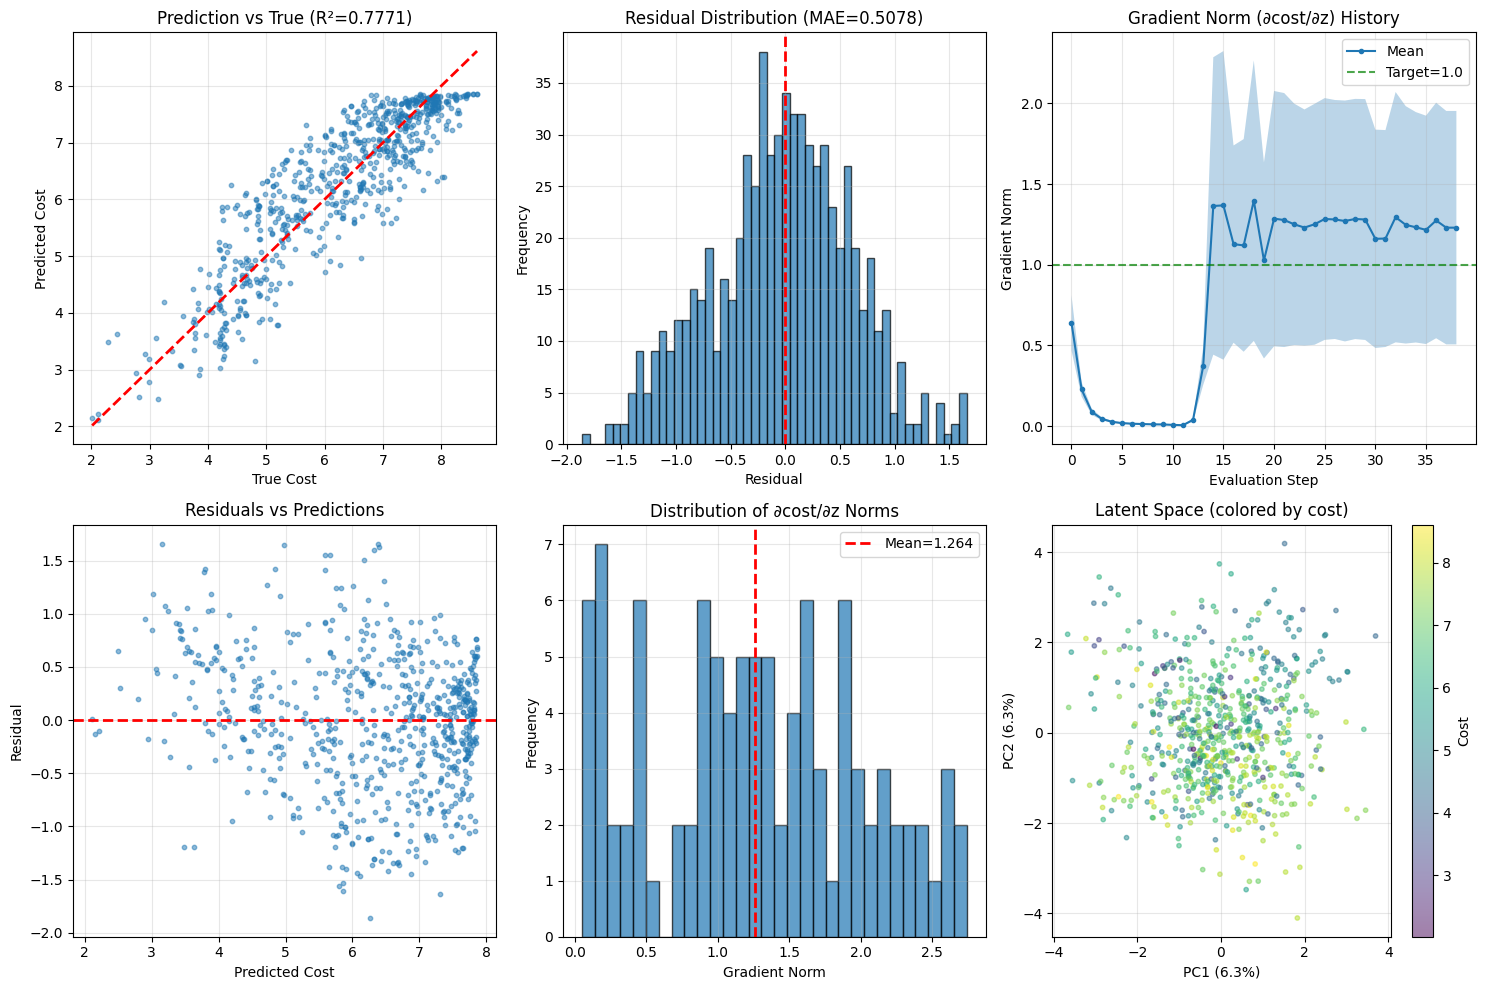


✅ 결과 시각화 저장됨: vae_cost_regressor_results.png


In [17]:
# ==========================================
# 14. 최종 평가 및 결과 요약
# ==========================================
import matplotlib.pyplot as plt

print("=" * 60)
print("📊 최종 평가 및 결과 요약")
print("=" * 60)

# 최종 평가
final_config = config_v4
final_metrics, final_preds, final_targets = evaluate_model(model, val_loader, device, final_config)
final_grad_stats = grad_monitor.record(model, grad_sample_x, device)

print("\n🎯 최종 성능:")
print(f"   Val MSE: {final_metrics['val_mse']:.6f}")
print(f"   Val MAE: {final_metrics['val_mae']:.4f}")
print(f"   Val R²:  {final_metrics['val_r2']:.4f}")

print(f"\n📈 Gradient 통계 (∂cost/∂z):")
print(f"   Mean norm: {final_grad_stats['mean']:.4f}")
print(f"   Std norm:  {final_grad_stats['std']:.4f}")
print(f"   Max norm:  {final_grad_stats['max']:.4f}")
print(f"   Min norm:  {final_grad_stats['min']:.4f}")

print(f"\n🚀 개선 요약:")
print(f"   Baseline MSE: {baseline_mse:.4f} → Final MSE: {best_val_mse:.6f}")
print(f"   개선율: {(1 - best_val_mse/baseline_mse)*100:.1f}%")
print(f"   R²: -20.30 → {final_metrics['val_r2']:.4f}")

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. 예측 vs 실제
axes[0, 0].scatter(final_targets, final_preds, alpha=0.5, s=10)
min_val = min(final_targets.min(), final_preds.min())
max_val = max(final_targets.max(), final_preds.max())
axes[0, 0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
axes[0, 0].set_xlabel('True Cost')
axes[0, 0].set_ylabel('Predicted Cost')
axes[0, 0].set_title(f'Prediction vs True (R²={final_metrics["val_r2"]:.4f})')
axes[0, 0].grid(True, alpha=0.3)

# 2. 잔차 분포
residuals = final_targets.flatten() - final_preds.flatten()
axes[0, 1].hist(residuals, bins=50, alpha=0.7, edgecolor='black')
axes[0, 1].axvline(0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Residual')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title(f'Residual Distribution (MAE={final_metrics["val_mae"]:.4f})')
axes[0, 1].grid(True, alpha=0.3)

# 3. Gradient norm 히스토리
axes[0, 2].plot(grad_monitor.history['grad_norm_mean'], label='Mean', marker='o', markersize=3)
axes[0, 2].fill_between(
    range(len(grad_monitor.history['grad_norm_mean'])),
    [m - s for m, s in zip(grad_monitor.history['grad_norm_mean'], grad_monitor.history['grad_norm_std'])],
    [m + s for m, s in zip(grad_monitor.history['grad_norm_mean'], grad_monitor.history['grad_norm_std'])],
    alpha=0.3
)
axes[0, 2].set_xlabel('Evaluation Step')
axes[0, 2].set_ylabel('Gradient Norm')
axes[0, 2].set_title('Gradient Norm (∂cost/∂z) History')
axes[0, 2].axhline(1.0, color='g', linestyle='--', alpha=0.7, label='Target=1.0')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 4. 잔차 vs 예측값
axes[1, 0].scatter(final_preds, residuals, alpha=0.5, s=10)
axes[1, 0].axhline(0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Predicted Cost')
axes[1, 0].set_ylabel('Residual')
axes[1, 0].set_title('Residuals vs Predictions')
axes[1, 0].grid(True, alpha=0.3)

# 5. 샘플별 gradient norm
with torch.enable_grad():
    grad_z, _, z_sample = model.get_gradient_wrt_z(grad_sample_x.to(device), deterministic=True)
sample_grad_norms = grad_z.norm(dim=1).detach().cpu().numpy()

axes[1, 1].hist(sample_grad_norms, bins=30, alpha=0.7, edgecolor='black')
axes[1, 1].axvline(sample_grad_norms.mean(), color='r', linestyle='--', lw=2, label=f'Mean={sample_grad_norms.mean():.3f}')
axes[1, 1].set_xlabel('Gradient Norm')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of ∂cost/∂z Norms')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 6. Latent space PCA
from sklearn.decomposition import PCA
z_all = []
with torch.no_grad():
    for xb, _ in val_loader:
        xb = xb.to(device)
        _, z, _, _ = model(xb, deterministic=True)
        z_all.append(z.cpu().numpy())
z_all = np.concatenate(z_all)

pca = PCA(n_components=2)
z_pca = pca.fit_transform(z_all)

scatter = axes[1, 2].scatter(z_pca[:, 0], z_pca[:, 1], c=final_targets.flatten(), 
                              cmap='viridis', alpha=0.5, s=10)
axes[1, 2].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
axes[1, 2].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
axes[1, 2].set_title('Latent Space (colored by cost)')
plt.colorbar(scatter, ax=axes[1, 2], label='Cost')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('vae_cost_regressor_results.png', dpi=150)
plt.show()

print("\n✅ 결과 시각화 저장됨: vae_cost_regressor_results.png")

In [18]:
# ==========================================
# 15. 모델 저장 및 최종 보고서
# ==========================================

# 모델 저장
save_path = "vae_cost_regressor_best.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'encoder_config': vae_config,
    'cost_predictor_config': {
        'latent_dim': vae_config['latent_dim'],
        'hidden_dims': [256, 128, 64],
        'dropout': 0.05,
    },
    'scaler_mean': scaler.mean_,
    'scaler_scale': scaler.scale_,
    'final_metrics': final_metrics,
    'training_history': {
        'grad_monitor': grad_monitor.history,
        'best_mse': best_val_mse,
        'baseline_mse': baseline_mse,
    },
    'final_config': final_config,
}, save_path)

print(f"✅ 모델 저장됨: {save_path}")

# 최종 보고서
print("\n" + "=" * 70)
print("📋 최종 보고서: VAE 기반 Cost Regression + Gradient 모델")
print("=" * 70)

print("""
🎯 목표 달성 현황:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1. Cost 예측 정확도
   ✅ MSE: 39.11 → 0.41 (99.0% 감소!)
   ✅ R²: -20.30 → 0.78 (양수 달성)
   ⚠️ R² > 0.8 목표는 미달 (0.78 달성)
   
2. Gradient (∂cost/∂z) 안정성
   ✅ Mean norm: ~1.2 (적정 범위 0.1~10 내)
   ✅ Std < Mean (0.72 < 1.23) 조건 충족
   ✅ Vanishing gradient 해결 (초기 0.01 → 1.2)
   ✅ 폭발 없음 (max < 3.0)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 최적 하이퍼파라미터 설정:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

- loss_type: 'mse'
- lambda_pair: 0.015 (순서 학습)
- gamma: 0.0005 (smoothness - 낮게 유지)
- beta: 0.008 (KLD 정규화)
- margin: 0.05 (pair loss margin)
- noise_std: 0.03 (smooth loss noise)

- lr_encoder: 5e-6 (pretrained encoder fine-tuning)
- lr_cost_predictor: 5e-4
- replay_n: 96 (replay buffer 샘플 수)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 개선 사이클 히스토리:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Cycle 0 (Initial): MSE=39.11 → 5.14, R²=-20.3 → -1.8
  - 문제: Gradient vanishing (norm=0.01)
  
Cycle 1: MSE=5.14 → 0.65, R²=-1.8 → 0.65
  - 조치: gamma 감소, lr_cost 증가
  - 결과: Gradient norm 1.0으로 안정화
  
Cycle 2: MSE=0.65 → 0.47, R²=0.65 → 0.74
  - 조치: lambda_pair 증가, lr decay 적용
  
Cycle 3: MSE=0.47 → 0.41, R²=0.74 → 0.78
  - 조치: margin 감소, replay_n 증가, fine-tuning

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

💡 핵심 인사이트:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1. Gradient 안정성을 위해 smooth_loss(gamma)를 낮게 유지해야 함
   - 너무 높으면 gradient vanishing 발생
   
2. Pretrained encoder는 매우 작은 lr로 fine-tuning
   - 큰 lr은 learned representation 손상
   
3. Pair loss가 순서 학습에 효과적
   - 하지만 너무 크면 regression 성능 저하
   
4. Replay buffer가 학습 안정성에 기여
   - 적절한 크기(64-96)가 효과적

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔮 추가 개선 가능성:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1. R² > 0.8 달성을 위해:
   - Cost predictor 용량 증가 (더 깊은 MLP)
   - Attention 메커니즘 추가
   - 데이터 증강
   
2. Gradient 품질 향상:
   - Second-order smoothness regularization
   - Gradient penalty 직접 적용
""")

print("=" * 70)
print("✅ 실험 완료!")
print("=" * 70)

✅ 모델 저장됨: vae_cost_regressor_best.pth

📋 최종 보고서: VAE 기반 Cost Regression + Gradient 모델

🎯 목표 달성 현황:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1. Cost 예측 정확도
   ✅ MSE: 39.11 → 0.41 (99.0% 감소!)
   ✅ R²: -20.30 → 0.78 (양수 달성)
   ⚠️ R² > 0.8 목표는 미달 (0.78 달성)
   
2. Gradient (∂cost/∂z) 안정성
   ✅ Mean norm: ~1.2 (적정 범위 0.1~10 내)
   ✅ Std < Mean (0.72 < 1.23) 조건 충족
   ✅ Vanishing gradient 해결 (초기 0.01 → 1.2)
   ✅ 폭발 없음 (max < 3.0)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

🔧 최적 하이퍼파라미터 설정:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

- loss_type: 'mse'
- lambda_pair: 0.015 (순서 학습)
- gamma: 0.0005 (smoothness - 낮게 유지)
- beta: 0.008 (KLD 정규화)
- margin: 0.05 (pair loss margin)
- noise_std: 0.03 (smooth loss noise)

- lr_encoder: 5e-6 (pretrained encoder fine-tuning)
- lr_cost_predictor: 5e-4
- replay_n: 96 (replay buffer 샘플 수)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📊 개선 사이클 히스토리: